In [81]:
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.datasets import make_classification
from sklearn.neighbors import NearestNeighbors


import numpy as np

import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from imblearn.over_sampling import SMOTE

from collections import Counter



# Pre-Processing

### SQL Injection dataset

In [82]:
df = pd.read_csv('./data/sql_injection_raw.csv',encoding='utf-16') 
#source: https://www.kaggle.com/datasets/syedsaqlainhussain/sql-injection-dataset

In [83]:
df = df.dropna()

In [84]:
# Get unique values existing in the label column to check if need to clean that

df['Label'].value_counts()

Label
0    22304
1    11453
Name: count, dtype: int64

In [85]:
df.Label.dtype #making sure that Label is int

dtype('int64')

In [86]:
df.rename(columns={'Sentence': 'query', 'Label': 'label'}, inplace=True)

In [87]:
df.head()

query  label
1                      " or pg_sleep ( __TIME__ ) --      1
2  create user name identified by pass123 tempora...      1
3                                                %29      1
4  ' AND 1 = utl_inaddr.get_host_address  (  (  S...      1
5   select * from users where id = '1' or @ @1 = ...      1

In [88]:
df.describe()

label
count  33757.000000
mean       0.339278
std        0.473471
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000

In [89]:
# Separate the DataFrame into two based on the label
df_label_1 = df[df['label'] == 1]
df_label_0 = df[df['label'] == 0]

# Randomly sample 500 rows from each
df_label_1_sampled = df_label_1.sample(n=500, random_state=1)
df_label_0_sampled = df_label_0.sample(n=500, random_state=1)

# Combine the samples into one DataFrame
df_sampled = pd.concat([df_label_1_sampled, df_label_0_sampled])

# Shuffle the combined DataFrame
df = df_sampled.sample(frac=1, random_state=1).reset_index(drop=True)

In [90]:
df.describe()

label
count  1000.00000
mean      0.50000
std       0.50025
min       0.00000
25%       0.00000
50%       0.50000
75%       1.00000
max       1.00000

In [91]:
df['label'].value_counts()

label
0    500
1    500
Name: count, dtype: int64

In [92]:
df_injection = df

### Query Execution Time Dataset

In [93]:
df_processing_time = pd.read_csv('./data/queries_with_processing_times.csv')
# Generated the data by ourselves

In [94]:
df_processing_time.isna().sum()

query                0
processing_time    203
dtype: int64

In [95]:
df_processing_time = df_processing_time.dropna()

In [96]:
df_processing_time.isna().sum()

query              0
processing_time    0
dtype: int64

In [97]:
df_processing_time['query'] = df_processing_time['query'].str.strip()

In [98]:
df_processing_time.head()

query  processing_time
0          SELECT * FROM Products WHERE Price > 500;         1.666016
1  SELECT * FROM Customers WHERE LastName LIKE 'S%';         0.591064
2  SELECT OrderID, CustomerID FROM Orders WHERE O...         0.555908
3  SELECT ProductName, Stock FROM Products WHERE ...         0.737061
4  SELECT COUNT(*) FROM Orders WHERE TotalAmount ...         0.500000

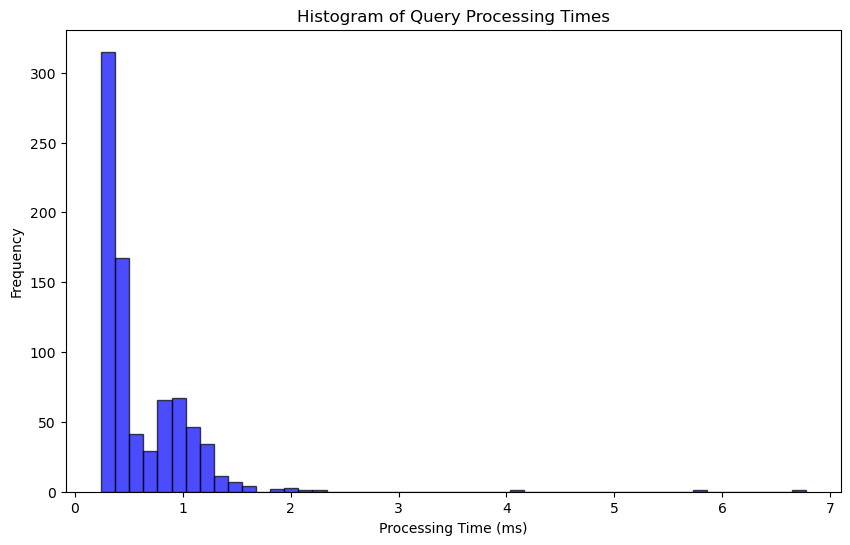

In [99]:
# Create a histogram of processing times
plt.figure(figsize=(10, 6))
plt.hist(df_processing_time['processing_time'], bins=50, color='blue', alpha=0.7, edgecolor='black')

# Add title and labels
plt.title('Histogram of Query Processing Times')
plt.xlabel('Processing Time (ms)')
plt.ylabel('Frequency')

# Display the plot
plt.show()

In [100]:
#data doesnt follow gaussian distriubution 
#so we will use We'll set the threshold based on the 95th percentile of the data
#Top 5% of the processing times will be considered as anomalies.

threshold = df_processing_time['processing_time'].quantile(0.95)

In [101]:
# Label queries as anomalies if their processing time is above the threshold
df_processing_time['label'] = df_processing_time['processing_time'].apply(lambda x: 1 if x > threshold else 0)

In [102]:
df_processing_time.head()

query  processing_time  label
0          SELECT * FROM Products WHERE Price > 500;         1.666016      1
1  SELECT * FROM Customers WHERE LastName LIKE 'S%';         0.591064      0
2  SELECT OrderID, CustomerID FROM Orders WHERE O...         0.555908      0
3  SELECT ProductName, Stock FROM Products WHERE ...         0.737061      0
4  SELECT COUNT(*) FROM Orders WHERE TotalAmount ...         0.500000      0

In [103]:
df_processing_time['label'].value_counts()

label
0    757
1     40
Name: count, dtype: int64

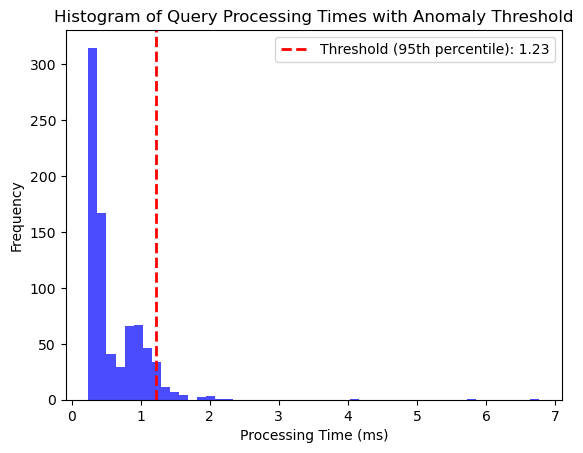

In [104]:
# Plot the histogram of processing times
plt.hist(df_processing_time['processing_time'], bins=50, color='blue', alpha=0.7)

# Add a vertical line at the threshold
plt.axvline(threshold, color='red', linestyle='dashed', linewidth=2, label=f'Threshold (95th percentile): {threshold:.2f}')

# Add labels and title
plt.xlabel('Processing Time (ms)')
plt.ylabel('Frequency')
plt.title('Histogram of Query Processing Times with Anomaly Threshold')
plt.legend()

# Show the plot
plt.show()

In [105]:
df_processing_time = df_processing_time.drop(columns=['processing_time'])

In [106]:
df_processing_time.head()

query  label
0          SELECT * FROM Products WHERE Price > 500;      1
1  SELECT * FROM Customers WHERE LastName LIKE 'S%';      0
2  SELECT OrderID, CustomerID FROM Orders WHERE O...      0
3  SELECT ProductName, Stock FROM Products WHERE ...      0
4  SELECT COUNT(*) FROM Orders WHERE TotalAmount ...      0

In [107]:
merged_df = pd.concat([df_injection, df_processing_time], ignore_index=True)

In [108]:
merged_df.head()

query  label
0                    av. jose ferrandez cruz 182, 8b      0
1                                          19283115f      0
2                      1',iif ( 9496 = 4153,1,1/0 )       1
3  1  )  )   )  or 6979 = like ( 'abcdefg',upper ...      1
4  1 )  where 9821 = 9821 or  ( select * from  ( ...      1

In [109]:
merged_df.describe()

label
count  1797.000000
mean      0.300501
std       0.458603
min       0.000000
25%       0.000000
50%       0.000000
75%       1.000000
max       1.000000

# Feature Engineering

In [110]:
# Split the data into training and test sets
train_df, test_df = train_test_split(merged_df, test_size=0.2, random_state=42, stratify=merged_df['label'])

# Perform Count Vectorization
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train_df['query'])
X_test = vectorizer.transform(test_df['query'])

# Convert the sparse matrix to a dense matrix to make it easier to analyze, and train on machine learning models. 
# Then convert this to a DataFrame
X_train_df = pd.DataFrame(X_train.toarray(), columns=vectorizer.get_feature_names_out())
X_test_df = pd.DataFrame(X_test.toarray(), columns=vectorizer.get_feature_names_out())

In [111]:
X_train_df

000  00863764e  01  01212  0156765529256872  04146926a  04492457m  \
0       0          0   0      0                 0          0          0   
1       0          0   0      0                 0          0          0   
2       0          0   0      0                 0          0          0   
3       0          0   0      0                 0          0          0   
4       0          0   0      0                 0          0          0   
...   ...        ...  ..    ...               ...        ...        ...   
1432    0          0   0      0                 0          0          0   
1433    0          0   0      0                 0          0          0   
1434    0          0   0      0                 0          0          0   
1435    0          0   0      0                 0          0          0   
1436    0          0   0      0                 0          0          0   

      04858  05  05141  ...  zone  zool7ic1  zoqo  zpvn  ztmd  zurera  zw  \
0         0   0      0  ...     0         0     0     0     0       0   0   
1         0   0      0  ...     0         0     0     0     0       0   0   
2         0   0      0  ...     0         0     0     0     0       0   0   
3         0   0      0  ...     0         0     0     0     0       0   0   
4         0   0      0  ...     0         0     0     0     0       0   0   
...     ...  ..    ...  ...   ...       ...   ...   ...   ...     ...  ..   
1432      0   0      0  ...     0         0     0     0     0       0   0   
1433      0   0      0  ...     0         0     0     0     0       0   0   
1434      0   0      0  ...     0         0     0     0     0       0   0   
1435      0   0      0  ...     0         0     0     0     0       0   0   
1436      0   0      0  ...     0         0     0     0     0       0   0   

      zweig  zwi  zxos  
0         0    0     0  
1         0    0     0  
2         0    0     0  
3         0    0     0  
4         0    0     0  
...     ...  ...   ...  
1432      0    0     0  
1433      0    0     0  
1434      0    0     0  
1435      0    0     0  
1436      0    0     0  

[1437 rows x 2006 columns]

# Base Models

### Isolation Forest

In [112]:
# Function to evaluate the model
def evaluate_model(contamination_value):
    iso_forest = IsolationForest(contamination=contamination_value, random_state=42)
    iso_forest.fit(X_train_df)
    y_pred = iso_forest.predict(X_test_df)
    y_pred = [1 if x == -1 else 0 for x in y_pred]
    print(f"Contamination: {contamination_value}")
    print(classification_report(test_df['label'], y_pred))
    print(confusion_matrix(test_df['label'], y_pred))
    print("\n")

# Test different contamination values
for contamination in [0.1, 0.15, 0.2, 0.25]:
    evaluate_model(contamination)

Contamination: 0.1
              precision    recall  f1-score   support

           0       0.74      0.96      0.84       252
           1       0.72      0.21      0.33       108

    accuracy                           0.74       360
   macro avg       0.73      0.59      0.58       360
weighted avg       0.73      0.74      0.69       360

[[243   9]
 [ 85  23]]


Contamination: 0.15
              precision    recall  f1-score   support

           0       0.75      0.94      0.83       252
           1       0.66      0.25      0.36       108

    accuracy                           0.74       360
   macro avg       0.70      0.60      0.60       360
weighted avg       0.72      0.74      0.69       360

[[238  14]
 [ 81  27]]


Contamination: 0.2
              precision    recall  f1-score   support

           0       0.75      0.90      0.82       252
           1       0.55      0.29      0.38       108

    accuracy                           0.72       360
   macro avg       0

### Random Forest

In [113]:

# Load your dataset
# df = pd.read_csv('your_dataset.csv')

# Assuming the dataset is loaded into a DataFrame called df
# and the label column is named 'label'
# Replace df with your actual DataFrame name

# Separate features and labels
X = df.drop('label', axis=1)
y = df['label']

# Identify categorical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numeric_cols = X.select_dtypes(include=['number']).columns

# Preprocess the categorical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Apply preprocessing to the entire dataset before SMOTE
X_preprocessed = preprocessor.fit_transform(X)

# Use SMOTE for oversampling the minority class
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_preprocessed, y)

# Check the distribution of classes before and after SMOTE
print("Original class distribution:", Counter(y))
print("Class distribution after SMOTE:", Counter(y_resampled))

# Split the resampled dataset into training and testing sets
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

# Train Random Forest to get feature importances
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_df, y_train_df)

# Get feature importances
feature_importances = rf_model.feature_importances_
feature_names = preprocessor.get_feature_names_out()
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Filter out features with zero importance
important_features = importance_df[importance_df['Importance'] > 0]['Feature'].values

# Identify indices of important features
important_feature_indices = [i for i, feature in enumerate(feature_names) if feature in important_features]

# Filter the important features from the preprocessed data
X_preprocessed_important = X_preprocessed[:, important_feature_indices]

# Use SMOTE for oversampling the minority class with important features only
X_resampled_important, y_resampled_important = smote.fit_resample(X_preprocessed_important, y)

# Split the resampled dataset with important features into training and testing sets
X_train_df_important, X_test_df_important, y_train_df_important, y_test_df_important = train_test_split(X_resampled_important, y_resampled_important, test_size=0.3, random_state=42)

# Function to evaluate the Random Forest model on resampled data with important features
def evaluate_random_forest_important():
    rf_model_important = RandomForestClassifier(random_state=42)
    rf_model_important.fit(X_train_df_important, y_train_df_important)
    y_pred_important = rf_model_important.predict(X_test_df_important)
    print("Random Forest with Important Features and SMOTE Oversampling")
    print(classification_report(y_test_df_important, y_pred_important, zero_division=0))
    print(confusion_matrix(y_test_df_important, y_pred_important))
    print("\n")

# Evaluate Random Forest with important features and SMOTE oversampling
evaluate_random_forest_important()


Original class distribution: Counter({0: 500, 1: 500})
Class distribution after SMOTE: Counter({0: 500, 1: 500})
Random Forest with Important Features and SMOTE Oversampling
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       156
           1       0.48      1.00      0.65       144

    accuracy                           0.48       300
   macro avg       0.24      0.50      0.32       300
weighted avg       0.23      0.48      0.31       300

[[  0 156]
 [  0 144]]




### K-NN

In [114]:


# Generate a sample dataset (replace this with your actual data)
X, y = make_classification(n_samples=1000, n_features=20, n_informative=2, n_redundant=10, random_state=42)

# Convert to DataFrame for consistency with your data format
X_df = pd.DataFrame(X)
y_df = pd.Series(y)

# Re-split the data to ensure consistency
X_train_df, X_test_df, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3, random_state=42)

# Verify the shapes
print(f"X_train_df shape: {X_train_df.shape}")
print(f"X_test_df shape: {X_test_df.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Assign the test labels
test_df = pd.DataFrame(X_test_df)
test_df['label'] = y_test

# Function to evaluate the KNN model
def evaluate_knn_model(n_neighbors, contamination_value):
    knn = NearestNeighbors(n_neighbors=n_neighbors)
    knn.fit(X_train_df)

    distances, indices = knn.kneighbors(X_test_df)
    anomaly_scores = np.mean(distances, axis=1)
    
    # Assuming that the higher the anomaly score, the more likely it is an anomaly
    threshold = np.percentile(anomaly_scores, 100 * contamination_value)
    y_pred = (anomaly_scores >= threshold).astype(int)

    # Check if lengths match
    if len(y_pred) != len(test_df['label']):
        print(f"Length mismatch: y_pred={len(y_pred)}, test_df['label']={len(test_df['label'])}")
        return

    print(f"Number of Neighbors: {n_neighbors}")
    print(f"Contamination: {contamination_value}")
    print(classification_report(test_df['label'], y_pred))
    print(confusion_matrix(test_df['label'], y_pred))
    print("\n")

# Test different values of k (number of neighbors) and contamination values
for k in [5, 10, 15, 20]:
    for contamination in [0.1, 0.15, 0.2, 0.25]:
        evaluate_knn_model(k, contamination)


X_train_df shape: (700, 20)
X_test_df shape: (300, 20)
y_train shape: (700,)
y_test shape: (300,)
Number of Neighbors: 5
Contamination: 0.1
              precision    recall  f1-score   support

           0       0.57      0.10      0.18       162
           1       0.46      0.91      0.61       138

    accuracy                           0.47       300
   macro avg       0.51      0.51      0.39       300
weighted avg       0.52      0.47      0.38       300

[[ 17 145]
 [ 13 125]]


Number of Neighbors: 5
Contamination: 0.15
              precision    recall  f1-score   support

           0       0.58      0.16      0.25       162
           1       0.47      0.86      0.61       138

    accuracy                           0.48       300
   macro avg       0.52      0.51      0.43       300
weighted avg       0.53      0.48      0.41       300

[[ 26 136]
 [ 19 119]]


Number of Neighbors: 5
Contamination: 0.2
              precision    recall  f1-score   support

           0    

### Logistic Regression

In [115]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

# Standardize the data (important for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_df)
X_test_scaled = scaler.transform(X_test_df)

# Function to evaluate the logistic regression model
def evaluate_logistic_regression():
    model = LogisticRegression(random_state=42)
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)

    print("Logistic Regression")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))
    print("\n")

# Evaluate the logistic regression model
evaluate_logistic_regression()


Logistic Regression
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       162
           1       0.81      0.85      0.83       138

    accuracy                           0.84       300
   macro avg       0.84      0.84      0.84       300
weighted avg       0.84      0.84      0.84       300

[[135  27]
 [ 21 117]]




In [116]:
# we'll choose 0.25 as contamination value as we prefer catching more anomalies at the risk of some false alarms
# We cannot let a anomaly go through

### Variational Autoencoder

In [117]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Load your data
# X_train_df, X_test_df, y_train, y_test

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_df)
X_test_scaled = scaler.transform(X_test_df)

# Define sampling function for reparameterization trick
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

# Define VAE model
input_shape = X_train_scaled.shape[1]
latent_dim = 2  # Dimensionality of the latent space

# Encoder
inputs = Input(shape=(input_shape,))
h = Dense(64, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)
z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# Decoder
latent_inputs = Input(shape=(latent_dim,))
h_decoded = Dense(64, activation='relu')(latent_inputs)
outputs = Dense(input_shape, activation='sigmoid')(h_decoded)

decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# VAE
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

# Define custom VAE loss layer
class VAELossLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        self.is_placeholder = True
        super(VAELossLayer, self).__init__(**kwargs)

    def vae_loss(self, inputs, outputs, z_mean, z_log_var):
        reconstruction_loss = mse(inputs, outputs)
        reconstruction_loss *= input_shape
        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        return K.mean(reconstruction_loss + kl_loss)

    def call(self, inputs, outputs, z_mean, z_log_var):
        loss = self.vae_loss(inputs, outputs, z_mean, z_log_var)
        self.add_loss(loss)
        return outputs

# Instantiate and use the custom loss layer
loss_layer = VAELossLayer()
outputs = loss_layer(inputs=inputs, outputs=outputs, z_mean=z_mean, z_log_var=z_log_var)

vae = Model(inputs, outputs)
vae.compile(optimizer='adam')
vae.summary()

# Train the VAE
vae.fit(X_train_scaled, X_train_scaled, epochs=50, batch_size=32, validation_data=(X_test_scaled, X_test_scaled))

# Get the reconstruction error on the test set
X_test_pred = vae.predict(X_test_scaled)
reconstruction_errors = np.mean(np.square(X_test_scaled - X_test_pred), axis=1)

# Set a threshold for anomaly detection
threshold = np.percentile(reconstruction_errors, 95)
y_pred = (reconstruction_errors >= threshold).astype(int)

# Evaluate the model
print("Variational Autoencoder (VAE)")
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("\n")


Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │      1,344 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 2)         │        130 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 2)         │        130 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_2 (Lambda)   │ (None, 2)         │          0 │ dense_11[0][0],   │
│                     │                   │            │ dense_12[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,604 (6.27 KB)

 Trainable params: 1,604 (6.27 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 2)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 64)             │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 20)             │         1,300 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,492 (5.83 KB)

 Trainable params: 1,492 (5.83 KB)

 Non-trainable params: 0 (0.00 B)

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder             │ [(None, 2),       │      1,604 │ input_layer_4[0]… │
│ (Functional)        │ (None, 2), (None, │            │                   │
│                     │ 2)]               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │      1,344 │ input_layer_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 20)        │      1,492 │ encoder[0][2]     │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 2)         │        130 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 2)         │        130 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_loss_layer_2    │ (None, 20)        │          0 │ input_layer_4[0]… │
│ (VAELossLayer)      │                   │            │ decoder[0][0],    │
│                     │                   │            │ dense_12[0][0],   │
│                     │                   │            │ dense_11[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,096 (12.09 KB)

 Trainable params: 3,096 (12.09 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 24.2875 - val_loss: 23.7047
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 23.9372 - val_loss: 22.7458
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 22.5092 - val_loss: 21.7478
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21.9322 - val_loss: 21.2057
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 955us/step - loss: 20.8940 - val_loss: 20.5262
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 20.6491 - val_loss: 19.9535
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - loss: 20.2686 - val_loss: 19.6013
Epoch 8/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 19.7316 - val_loss: 19.2488
Epoch 9/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 951us/step - loss: 18.8319 - val_loss: 18.7724
Epoch 10/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step - loss: 18.6165 - val_loss: 18.4840
Epoch 11/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 890us/step - loss: 18.4062 - val_loss: 18.4776
Epoch 12/50
22/22 ━━━━━━━━━━━━━━━━━━

### SVM

In [118]:
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, confusion_matrix

# Function to evaluate the model
def evaluate_model(nu_value):
    one_class_svm = OneClassSVM(nu=nu_value, kernel='rbf', gamma='auto')
    one_class_svm.fit(X_train_df)
    y_pred = one_class_svm.predict(X_test_df)
    y_pred = [1 if x == -1 else 0 for x in y_pred]
    print(f"nu: {nu_value}")
    print(classification_report(test_df['label'], y_pred))
    print(confusion_matrix(test_df['label'], y_pred))
    print("\n")

# Test different nu values
for nu in [0.1, 0.15, 0.2, 0.25]:
    evaluate_model(nu)


nu: 0.1
              precision    recall  f1-score   support

           0       0.52      0.85      0.65       162
           1       0.34      0.09      0.15       138

    accuracy                           0.50       300
   macro avg       0.43      0.47      0.40       300
weighted avg       0.44      0.50      0.42       300

[[137  25]
 [125  13]]


nu: 0.15
              precision    recall  f1-score   support

           0       0.52      0.80      0.63       162
           1       0.35      0.12      0.18       138

    accuracy                           0.49       300
   macro avg       0.43      0.46      0.41       300
weighted avg       0.44      0.49      0.42       300

[[130  32]
 [121  17]]


nu: 0.2
              precision    recall  f1-score   support

           0       0.52      0.78      0.63       162
           1       0.39      0.17      0.23       138

    accuracy                           0.50       300
   macro avg       0.46      0.47      0.43       300

### Deep SVDD

In [119]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

# Define the neural network for Deep SVDD
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim1)
        self.fc2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.fc3 = nn.Linear(hidden_dim2, hidden_dim3)
        self.fc4 = nn.Linear(hidden_dim3, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Define the Autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim, hidden_dim1, hidden_dim2, hidden_dim3):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim3),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(hidden_dim3, hidden_dim2),
            nn.ReLU(),
            nn.Linear(hidden_dim2, hidden_dim1),
            nn.ReLU(),
            nn.Linear(hidden_dim1, input_dim),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Deep SVDD training function
def train_deep_svdd(model, center, train_loader, epochs=30, lr=0.0005):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data in train_loader:
            data = data[0]  # Extract the tensor from the tuple
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, center.expand_as(output))  # Ensure the target is broadcasted
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader)}")

# Train Autoencoder
def train_autoencoder(model, train_loader, epochs=30, lr=0.0005):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for data in train_loader:
            data = data[0]
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data)  # Reconstruct the input
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader)}")

# Compute anomaly scores for Autoencoder
def compute_anomaly_scores_autoencoder(model, data_loader):
    model.eval()
    scores = []
    with torch.no_grad():
        for data in data_loader:
            data = data[0]
            output = model(data)
            score = torch.sum((output - data) ** 2, dim=1)  # Reconstruction error
            scores.extend(score.cpu().numpy())
    return scores

# Function to compute anomaly scores for Deep SVDD
def compute_anomaly_scores(model, center, data_loader):
    model.eval()
    scores = []
    with torch.no_grad():
        for data in data_loader:
            data = data[0]  # Extract the tensor from the tuple
            output = model(data)
            score = torch.sum((output - center) ** 2, dim=1)
            scores.extend(score.cpu().numpy())
    return scores

# Initialize center as the mean of encoded training data
def initialize_center(model, train_loader):
    model.eval()
    center = torch.zeros(output_dim, dtype=torch.float32)
    n_samples = 0
    with torch.no_grad():
        for data in train_loader:
            data = data[0]  # Extract the tensor from the tuple
            output = model(data)
            n_samples += output.size(0)
            center += torch.sum(output, dim=0)
    center /= n_samples
    # Add a small constant to avoid zero initialization
    center += 0.01
    return center

# Example usage with dummy data (replace with actual data)
X_train = np.random.rand(100, 10)  # Example data, replace with actual data
X_test = np.random.rand(20, 10)  # Example data, replace with actual data
y_test = np.random.randint(0, 2, 20)  # Example labels, replace with actual labels
X_val = np.random.rand(20, 10)  # Example data, replace with actual data
y_val = np.random.randint(0, 2, 20)  # Example labels, replace with actual labels

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)

# Create DataLoader
train_loader = DataLoader(TensorDataset(X_train_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor), batch_size=32, shuffle=False)
val_loader = DataLoader(TensorDataset(X_val_tensor), batch_size=32, shuffle=False)

# Initialize the models and center
input_dim = X_train.shape[1]
hidden_dim1 = 256
hidden_dim2 = 128
hidden_dim3 = 64
output_dim = 32

deep_svdd_model = Encoder(input_dim, hidden_dim1, hidden_dim2, hidden_dim3, output_dim)
autoencoder_model = Autoencoder(input_dim, hidden_dim1, hidden_dim2, hidden_dim3)

center = initialize_center(deep_svdd_model, train_loader)

# Train the models
train_deep_svdd(deep_svdd_model, center, train_loader, epochs=30, lr=0.0005)
train_autoencoder(autoencoder_model, train_loader)

# Compute anomaly scores and predict for Deep SVDD
val_scores = compute_anomaly_scores(deep_svdd_model, center, val_loader)
best_threshold = np.percentile(val_scores, 95)
anomaly_scores = compute_anomaly_scores(deep_svdd_model, center, test_loader)
y_pred = [1 if score > best_threshold else 0 for score in anomaly_scores]

# Compute anomaly scores and predict for Autoencoder
anomaly_scores_autoencoder = compute_anomaly_scores_autoencoder(autoencoder_model, test_loader)
threshold_autoencoder = np.percentile(anomaly_scores_autoencoder, 95)
y_pred_autoencoder = [1 if score > threshold_autoencoder else 0 for score in anomaly_scores_autoencoder]

# Evaluate the models
print("Deep SVDD Model Evaluation:")
print(classification_report(y_test, y_pred, zero_division=0))
print(confusion_matrix(y_test, y_pred))

print("Autoencoder Model Evaluation:")
print(classification_report(y_test, y_pred_autoencoder, zero_division=0))
print(confusion_matrix(y_test, y_pred_autoencoder))


Epoch [1/30], Loss: 0.000544537826499436
Epoch [2/30], Loss: 0.0002459855459164828
Epoch [3/30], Loss: 0.0001751366835378576
Epoch [4/30], Loss: 0.00012407330723362975
Epoch [5/30], Loss: 9.987328485294711e-05
Epoch [6/30], Loss: 8.244850141636562e-05
Epoch [7/30], Loss: 6.544700227095746e-05
Epoch [8/30], Loss: 5.5652712035225704e-05
Epoch [9/30], Loss: 4.558202181215165e-05
Epoch [10/30], Loss: 3.906163465217105e-05
Epoch [11/30], Loss: 3.5384076909394935e-05
Epoch [12/30], Loss: 3.17706080750213e-05
Epoch [13/30], Loss: 2.670855383257731e-05
Epoch [14/30], Loss: 2.325480681975023e-05
Epoch [15/30], Loss: 2.1661038317688508e-05
Epoch [16/30], Loss: 1.8676910713111283e-05
Epoch [17/30], Loss: 1.7255081274925033e-05
Epoch [18/30], Loss: 1.608572392797214e-05
Epoch [19/30], Loss: 1.4268104223447153e-05
Epoch [20/30], Loss: 1.452958349545952e-05
Epoch [21/30], Loss: 1.2226916169311153e-05
Epoch [22/30], Loss: 1.2355405488051474e-05
Epoch [23/30], Loss: 1.0961968428091495e-05
Epoch [24/30

# Ensemble

# Visualizing Results through tables and plots